In [1]:
import collections
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
import tensorflow_text as tf_text

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

In [3]:
dataset_dir = '..\\data'
train_dir = f"{dataset_dir}\\tr"
batch_size = 32
seed = 42

In [4]:
def labeler(example, index):
    return example, tf.cast(index, tf.int64)

In [5]:
FILE_NAMES = ['negativesentences.txt', 'neutralsentences.txt', 'positivesentences.txt']
labeled_data_sets = []
# Give labels to the data, 0 for negatives, 1 for neutrals, 2 for positives.
for i, file_name in enumerate(FILE_NAMES):
    lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\{file_name}")
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_data_sets.append(labeled_dataset)

In [6]:
BUFFER_SIZE = 50000
BATCH_SIZE = 32
VALIDATION_SIZE = 5000
VOCAB_SIZE = 35000

In [7]:
# concatenate all labeled datasets into one and shuffle
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

In [8]:
print('Labels are 0 = negative, 1 = neutral, 2 = positive.\n')
for text, label in all_labeled_data.take(10):
    print("Sentence: ", text.numpy())
    print("Label:", label.numpy())

Labels are 0 = negative, 1 = neutral, 2 = positive.

Sentence:  b'Itku on ollut pinnassa.'
Label: 0
Sentence:  b'v: 2008 oikeuteen meni jopa kymmeni\xc3\xa4 nettirikos tapauksia'
Label: 1
Sentence:  b'Tarkoitan, ett\xc3\xa4 jos h\xc3\xa4n haluaakin pit\xc3\xa4\xc3\xa4 tiukempaa kuria, kuin mihin ollaan totuttu.'
Label: 1
Sentence:  b'Ja turpiin kunnolla...'
Label: 0
Sentence:  b'Siin\xc3\xa4 oli sellanen naru kiinni, mutta se nyt sy\xc3\xb6tiin minuutissa...'
Label: 1
Sentence:  b'Ongelma on se ett\xc3\xa4 alle 300 e t\xc3\xa4st\xc3\xa4 summasta puuttuu ja t\xc3\xa4t\xc3\xa4 varten olen suunnitellut _alustavasti_ anoa jonkinlaisen kulutusluoton tai vipin.'
Label: 1
Sentence:  b'Mik\xc3\xa4 miehi\xc3\xa4 vaivaa?'
Label: 1
Sentence:  b'No t\xc3\xa4ss\xc3\xa4 aika vasta ajattelin v\xc3\xa4h\xc3\xa4 "yll\xc3\xa4tt\xc3\xa4\xc3\xa4" poikakaverini..'
Label: 1
Sentence:  b'Jopas sit\xc3\xa4 on Tepi-boy pahasti sekaisin viikon Alppi-tourin j\xc3\xa4lkeen et sillei hei!'
Label: 0
Sentence:  b'me

In [9]:
tokenizer = tf_text.UnicodeScriptTokenizer()

In [10]:
def tokenize(text, unused_label):
    lower_case = tf_text.case_fold_utf8(text)
    return tokenizer.tokenize(lower_case)

tokenized_ds = all_labeled_data.map(tokenize)

Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


In [11]:
for text_batch in tokenized_ds.take(5):
    print("Tokens: ", text_batch.numpy())

Tokens:  [b'itku' b'on' b'ollut' b'pinnassa' b'.']
Tokens:  [b'v' b':2008' b'oikeuteen' b'meni' b'jopa' b'kymmeni\xc3\xa4'
 b'nettirikos' b'tapauksia']
Tokens:  [b'tarkoitan' b',' b'ett\xc3\xa4' b'jos' b'h\xc3\xa4n' b'haluaakin'
 b'pit\xc3\xa4\xc3\xa4' b'tiukempaa' b'kuria' b',' b'kuin' b'mihin'
 b'ollaan' b'totuttu' b'.']
Tokens:  [b'ja' b'turpiin' b'kunnolla' b'...']
Tokens:  [b'siin\xc3\xa4' b'oli' b'sellanen' b'naru' b'kiinni' b',' b'mutta' b'se'
 b'nyt' b'sy\xc3\xb6tiin' b'minuutissa' b'...']


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
    return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
tokenized_ds = configure_dataset(tokenized_ds)

vocab_dict = collections.defaultdict(lambda: 0)
for toks in tokenized_ds.as_numpy_iterator():
    for tok in toks:
        vocab_dict[tok] += 1

vocab = sorted(vocab_dict.items(), key=lambda x: x[1], reverse=True)
vocab = [token for token, count in vocab]
vocab = vocab[:VOCAB_SIZE]
vocab_size = len(vocab)
print("Vocab size: ", vocab_size)
n = 500
print(f"First {n} vocab entries:", vocab[-50:-1])

Vocab size:  35000
First 500 vocab entries: [b'kokoomusm\xc3\xa4t\xc3\xa4', b'tuhoava', b'harhainen', b'l\xc3\xa4pl\xc3\xa4p', b'spekuloiminen', b'ajanviete', b'ty\xc3\xb6llistyminen', b'ihanteella', b'ihanteilla', b'bodyguard', b'assassin', b'koodinimi', b'googlasin', b'taustoittamaan', b'kapinallinen', b'ep\xc3\xa4r\xc3\xb6i', b'politrukin', b'nagan', b'kuivasti', b'pakeneminenb', b'siamilainen', b'persialainen', b'lyhytkarva', b'abessinialainen', b'keputorvelo', b'kerrattain', b'vaalikauden', b'kuljetusta', b'kent\xc3\xa4lle', b'potentiaalinen', b'harjoittamaa', b'laintynk\xc3\xa4\xc3\xa4', b'tapauksiin', b'kaivelen', b'((', b'fgetc', b'sorsa', b'))!=', b'eof', b'=~', b'fputc', b'krypt', b');}', b'm\xc3\xa4kihyppy', b'130,', b'innsbruck', b'aut', b'1=', b'schmitt']


In [14]:
keys = vocab
values = range(2, len(vocab) + 2)  # reserve 0 for padding, 1 for OOV

init = tf.lookup.KeyValueTensorInitializer(
    keys, values, key_dtype=tf.string, value_dtype=tf.int64)

num_oov_buckets = 1
vocab_table = tf.lookup.StaticVocabularyTable(init, num_oov_buckets)

In [15]:
def preprocess_text(text, label):
    standardized = tf_text.case_fold_utf8(text)
    tokenized = tokenizer.tokenize(standardized)
    vectorized = vocab_table.lookup(tokenized)
    return vectorized, label

In [16]:
example_text, example_label = next(iter(all_labeled_data))
print("Sentence: ", example_text.numpy())
vectorized_text, example_label = preprocess_text(example_text, example_label)
print("Vectorized sentence: ", vectorized_text.numpy())

Sentence:  b'Itku on ollut pinnassa.'
Vectorized sentence:  [2642    5   57 7958    2]


In [17]:
all_encoded_data = all_labeled_data.map(preprocess_text)

train_data = all_encoded_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE)
validation_data = all_encoded_data.take(VALIDATION_SIZE)

train_data = train_data.padded_batch(BATCH_SIZE)
validation_data = validation_data.padded_batch(BATCH_SIZE)

In [18]:
sample_text, sample_labels = next(iter(validation_data))
print("Text batch shape: ", sample_text.shape)
print("Label batch shape: ", sample_labels.shape)
print("First text example: ", sample_text[0])
print("First label example: ", sample_labels[0])

Text batch shape:  (32, 35)
Label batch shape:  (32,)
First text example:  tf.Tensor(
[2642    5   57 7958    2    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0], shape=(35,), dtype=int64)
First label example:  tf.Tensor(0, shape=(), dtype=int64)


In [19]:
vocab_size += 2

In [20]:
train_data = configure_dataset(train_data)
validation_data = configure_dataset(validation_data)

In [21]:
def create_model(vocab_size, num_labels):
    model = tf.keras.Sequential([
        layers.Embedding(vocab_size, 64, embeddings_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), mask_zero=True),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(32)),
        layers.Dropout(0.5),
        layers.Dense(32, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels)
  ])
    return model

In [22]:
model = create_model(vocab_size=vocab_size, num_labels=3)
model.summary()
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=1)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
history = model.fit(train_data, validation_data=validation_data, callbacks=[early_stop], epochs=15)
model.save('model/first.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          2240128   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

In [23]:
test_loss, test_acc = model.evaluate(validation_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

157/157 [==============================] - 7s 35ms/step - loss: 0.7265 - accuracy: 0.7584
Test Loss: 0.7264693975448608
Test Accuracy: 0.758400022983551


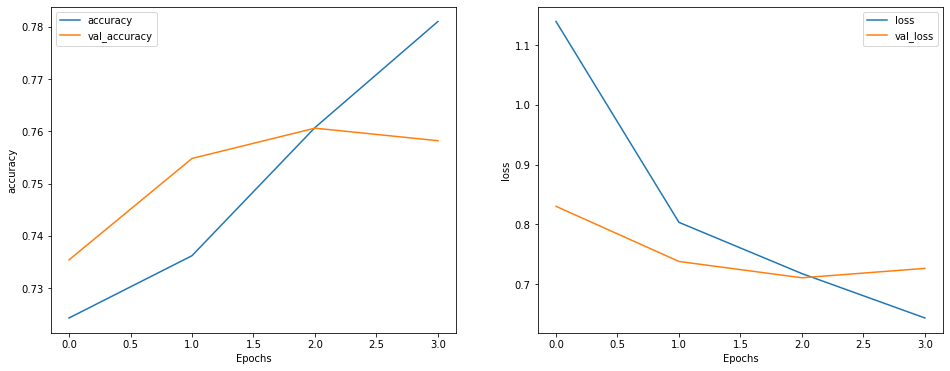

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [25]:
MAX_SEQUENCE_LENGTH = 250
preprocess_layer = TextVectorization(
    max_tokens=vocab_size,
    standardize=tf_text.case_fold_utf8,
    split=tokenizer.tokenize,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)
preprocess_layer.set_vocabulary(vocab)

In [26]:
export_model = tf.keras.Sequential(
    [preprocess_layer, model,
     layers.Activation('softmax')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

In [27]:
# Create a test dataset of raw strings
test_ds = all_labeled_data.take(VALIDATION_SIZE).batch(BATCH_SIZE)
test_ds = configure_dataset(test_ds)
loss, accuracy = export_model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: {:2.2%}".format(accuracy))

157/157 [==============================] - 31s 57ms/step - loss: 0.7267 - accuracy: 0.7584
Loss:  0.7266668677330017
Accuracy: 75.84%


In [28]:
inputs = [
    "Saatanan paskiaiset eikö teillä Vimpeliläisillä ole muuta kuin paskaa jauhaa jostain teidän etujen puolustajajasta.",  # Label: 0
    "Kela hyväksyy vesimenot 20,60 euroon asti kuussa per asukas asuinpaikasta riippumatta. ",  # Label: 1
    "Sä oot mulle niin tärkeä ja rakas!"  # Label: 2
]
predicted_scores = export_model.predict(inputs)
print(predicted_scores)
predicted_labels = tf.argmax(predicted_scores, axis=1)
for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label.numpy())

[[0.2719343  0.5865147  0.14155094]
 [0.05486251 0.9379933  0.00714426]
 [0.15935045 0.06238336 0.77826625]]
Question:  Saatanan paskiaiset eikö teillä Vimpeliläisillä ole muuta kuin paskaa jauhaa jostain teidän etujen puolustajajasta.
Predicted label:  1
Question:  Kela hyväksyy vesimenot 20,60 euroon asti kuussa per asukas asuinpaikasta riippumatta. 
Predicted label:  1
Question:  Sä oot mulle niin tärkeä ja rakas!
Predicted label:  2


In [29]:
inputs = [
    "Alkaa vituttamaan nuo saatanan rengasmainokset, jotka pomppii koko ajan silmille.", # Label: 0
    "Joka vitun asiassa ne vaan ajattelee seksiä ja haluaa vaan sitä.", # Label: 0
    "Mitä olit niin itserakas, nyt se sitten on mennyt päähäsi!", # Label: 0
    "Huumekuolemat johtuvat lähes poikkeuksetta ylianostuksista ja nekin kovien huumeiden kyseessäollen.", # Label: 1
    "Presidenttihän ei saa edustaa omaa poliittista vakaumustaan.",  # Label: 1
    "Lopulta voi käydä myös niin, että vaikka olettekin olleet yhdessä ja nauttineet keskenänne paljosta rakkaudesta," \
" te ette ole enää oikeita kumppaneita seuraavaa vaihetta varten." # Label: 1
    "Tänäänkin kaipaan kainaloa, hymyäsi ja ennenkaikkea halaustasi pusuista puhumattakaan.",  # Label: 2
    "Saan rakastella ja rakastaa häntä jälleen, Laitan hyvää ruokaa ja hieron hartioita.", # Label: 2
    "Hyvää syksynjatkoa kaikille lukijoilleni ja kiitos kommenteistanne." # Label: 2    
]
predicted_scores = export_model.predict(inputs)
predicted_labels = tf.argmax(predicted_scores, axis=1)
for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label.numpy())

Question:  Alkaa vituttamaan nuo saatanan rengasmainokset, jotka pomppii koko ajan silmille.
Predicted label:  2
Question:  Joka vitun asiassa ne vaan ajattelee seksiä ja haluaa vaan sitä.
Predicted label:  1
Question:  Mitä olit niin itserakas, nyt se sitten on mennyt päähäsi!
Predicted label:  1
Question:  Huumekuolemat johtuvat lähes poikkeuksetta ylianostuksista ja nekin kovien huumeiden kyseessäollen.
Predicted label:  1
Question:  Presidenttihän ei saa edustaa omaa poliittista vakaumustaan.
Predicted label:  1
Question:  Lopulta voi käydä myös niin, että vaikka olettekin olleet yhdessä ja nauttineet keskenänne paljosta rakkaudesta, te ette ole enää oikeita kumppaneita seuraavaa vaihetta varten.Tänäänkin kaipaan kainaloa, hymyäsi ja ennenkaikkea halaustasi pusuista puhumattakaan.
Predicted label:  1
Question:  Saan rakastella ja rakastaa häntä jälleen, Laitan hyvää ruokaa ja hieron hartioita.
Predicted label:  2
Question:  Hyvää syksynjatkoa kaikille lukijoilleni ja kiitos komment